In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import date
from scipy import stats
from scipy.stats import skew

import warnings
warnings.filterwarnings("ignore")

In [97]:
df = pd.read_csv("/Users/allisonkelly/Documents/Notebooks/user_behavior_analysis/data/interim/paid.csv", 
                 header=0, 
                 index_col=0).reset_index(drop=True)

In [98]:
df.head()

team_id   account_start_date       trial_end_date  mocks_count  \
0        1  2017-01-10 15:45:21                  NaN           73   
1       57  2017-01-11 12:48:38                  NaN            1   
2       82  2017-01-14 22:08:41                  NaN            6   
3      101  2017-01-22 09:14:29                  NaN            1   
4      151  2017-02-11 01:29:34  2017-02-26 01:29:38            1   

   entities_count  intents_count  variables_count           last_login  \
0               7             41               27  2020-12-05 23:24:18   
1               0              0                0  2020-08-26 00:13:38   
2               0              0                0                  NaN   
3               0              0                0                  NaN   
4               0              0                0                  NaN   

               sub_end   stripe_plan  members  reviewers  testers  \
0                  NaN      pro-plan        7          0        8   
1  2017-02-15 07:07:30     solo-plan        0          0        0   
2                  NaN  starter-plan        2          0        0   
3  2017-03-19 06:54:32  starter-plan        4          0        0   
4  2017-02-26 01:29:38  starter-plan        2          0        0   

   is_enterprise  churned  
0              0        0  
1              0        1  
2              0        0  
3              0        1  
4              0        1

### Categorical Features

'stripe_plan'<br>
'is_enterprise'<br>
'churned' <br>

### Continuous Features

'account_start_date'<br>
'trial_end_date'<br>
'last_login'<br>
'sub_end'<br>

### Discrete Features

'mocks_count'<br>
'entities_count'<br>
'intents_count'<br>
'variables_count'<br>
'members'<br>
'reviewers'<br>
'testers'<br>

In [99]:
# Show counts of churned versus un-churned users
df.groupby('churned').count()['team_id']

churned
0    217
1    930
Name: team_id, dtype: int64

Over 80% of users who started paid accounts since January 10, 2017 have churned.

In [100]:
features = df.drop(['account_start_date','trial_end_date','last_login','sub_end','stripe_plan'],axis=1)

We'll begin modeling with only discrete features with the goal of identifying which of the features have the greatest impact on our target, which is churn. None of the discrete featurs have any null values, so we can dive right into exploration. 

In [101]:
features.isnull().any()

team_id            False
mocks_count        False
entities_count     False
intents_count      False
variables_count    False
members            False
reviewers          False
testers            False
is_enterprise      False
churned            False
dtype: bool

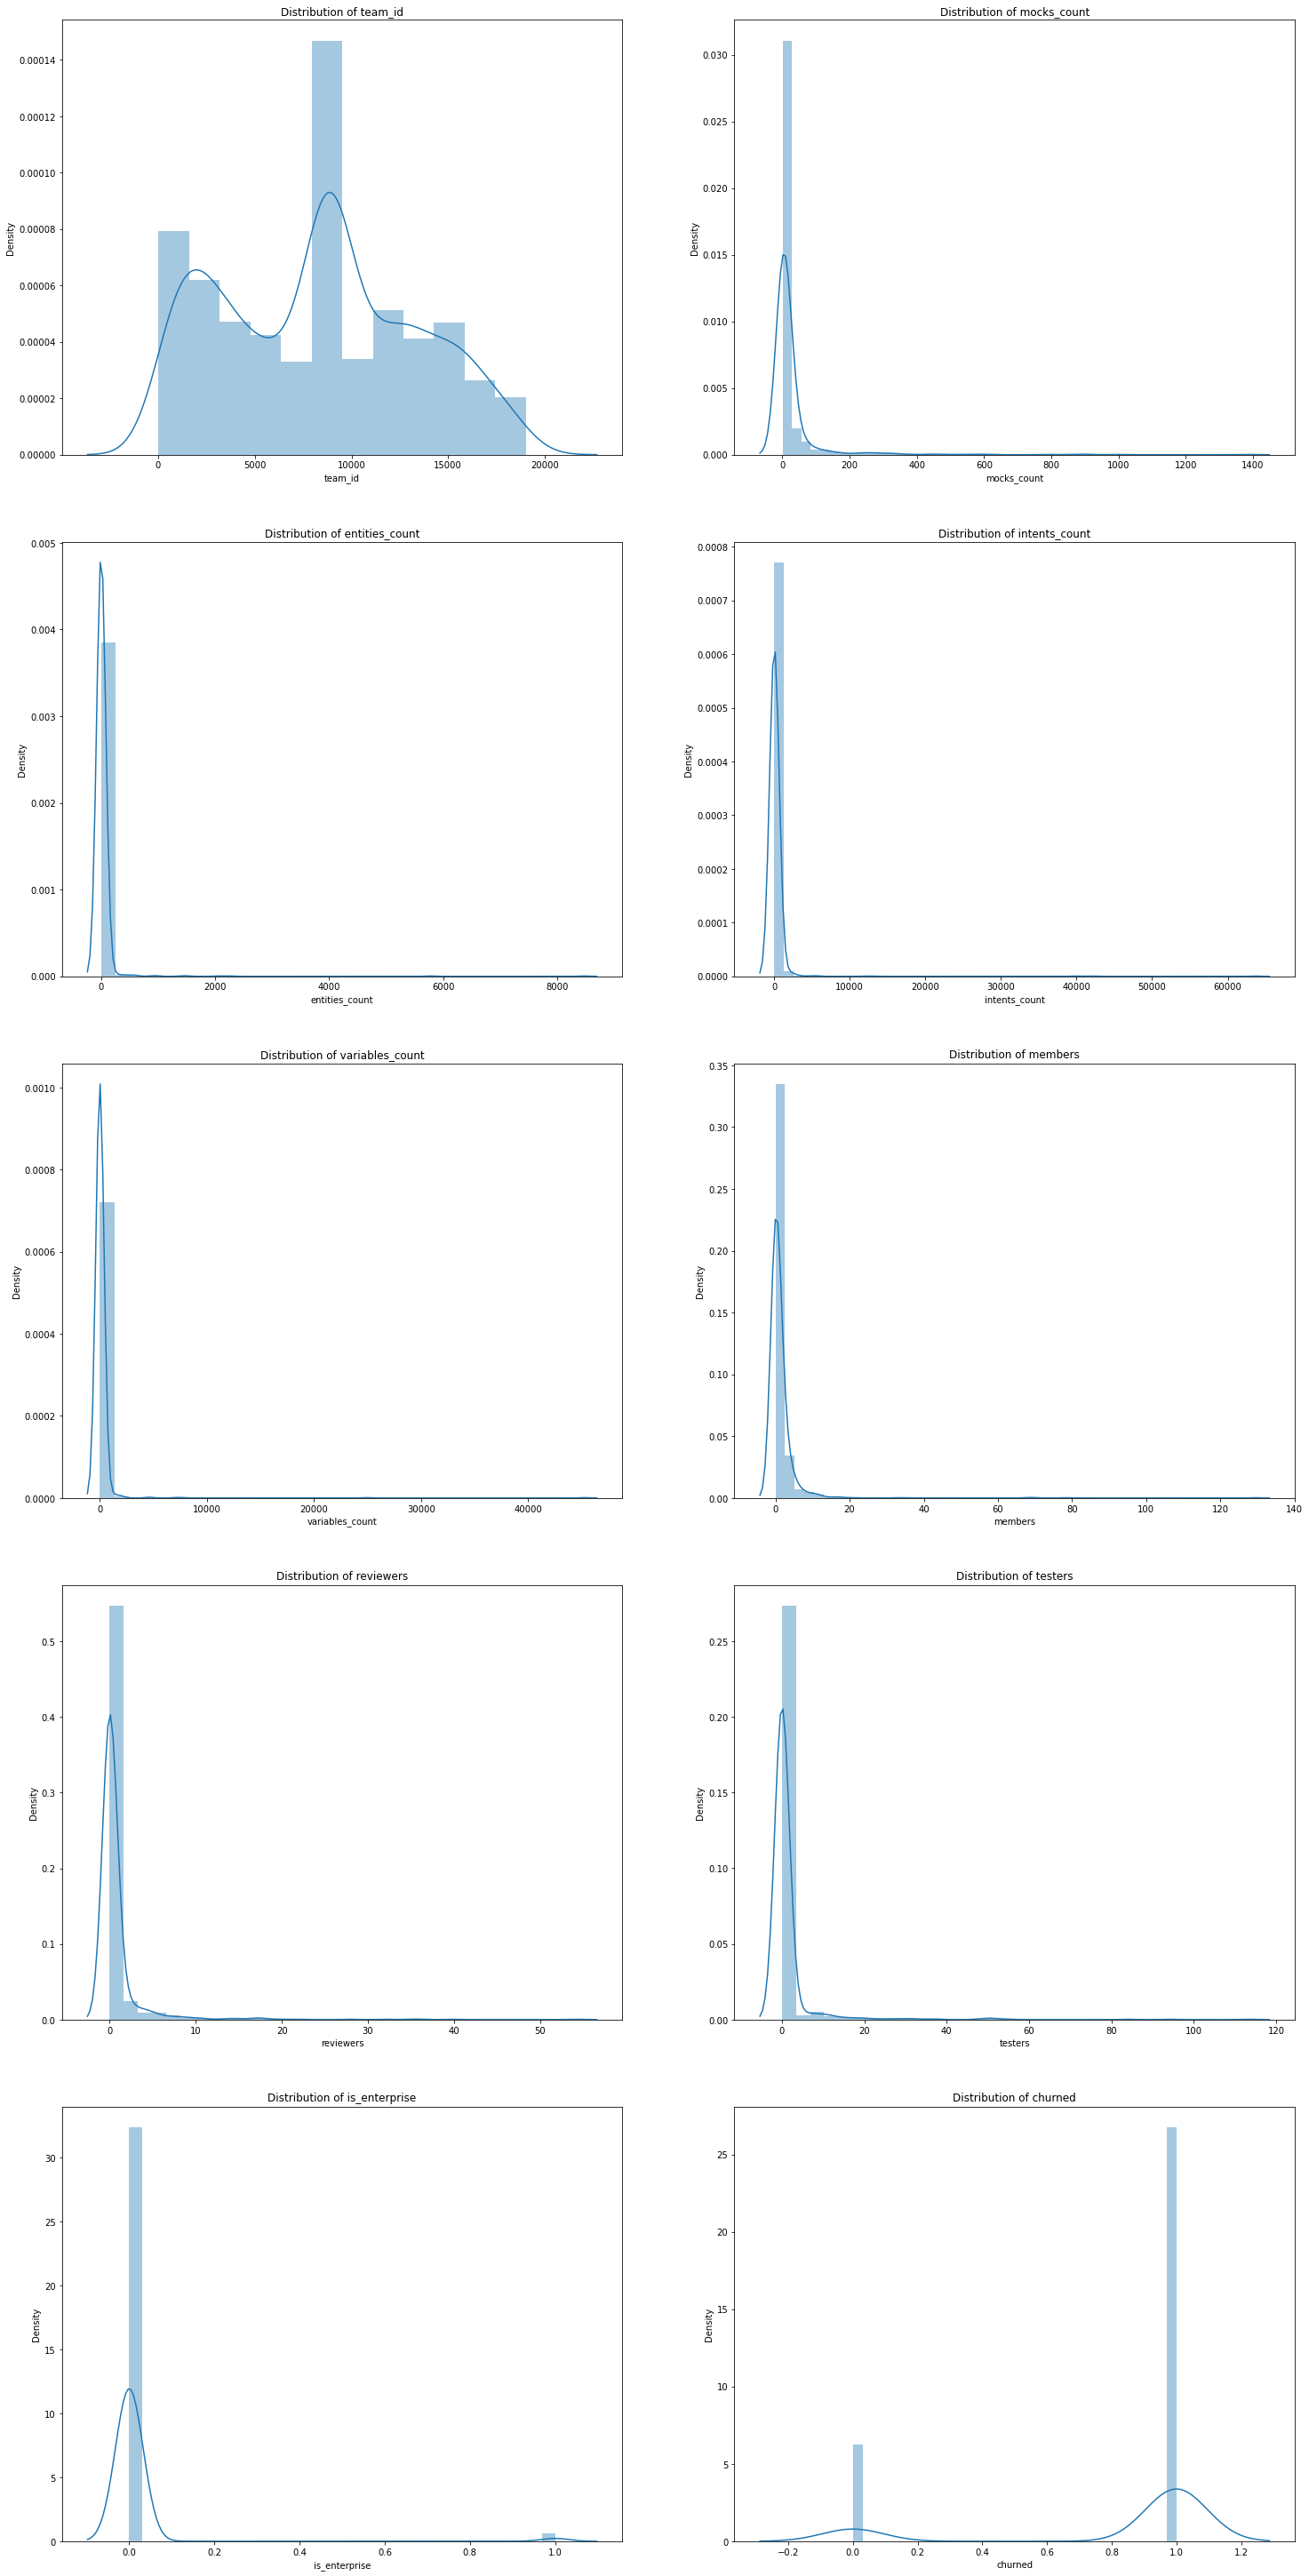

In [102]:
# Plotting normalized distribution plots of features we're going to test
%matplotlib inline
fig = plt.subplots(figsize=(20, 40))
plt.tight_layout()

for plot, col in zip(range(1,11), features.columns):
    
    plt.subplot(5,2,plot)
    sns.distplot(features[col],norm_hist=True)
    plt.title(f"Distribution of {col}")

In [103]:
for col in features.columns:
    print(f'Skewness of {col}: {round(skew(features[col]),3)}')

Skewness of team_id: 0.134
Skewness of mocks_count: 7.909
Skewness of entities_count: 20.683
Skewness of intents_count: 19.872
Skewness of variables_count: 24.228
Skewness of members: 14.837
Skewness of reviewers: 8.178
Skewness of testers: 8.922
Skewness of is_enterprise: 7.186
Skewness of churned: -1.587


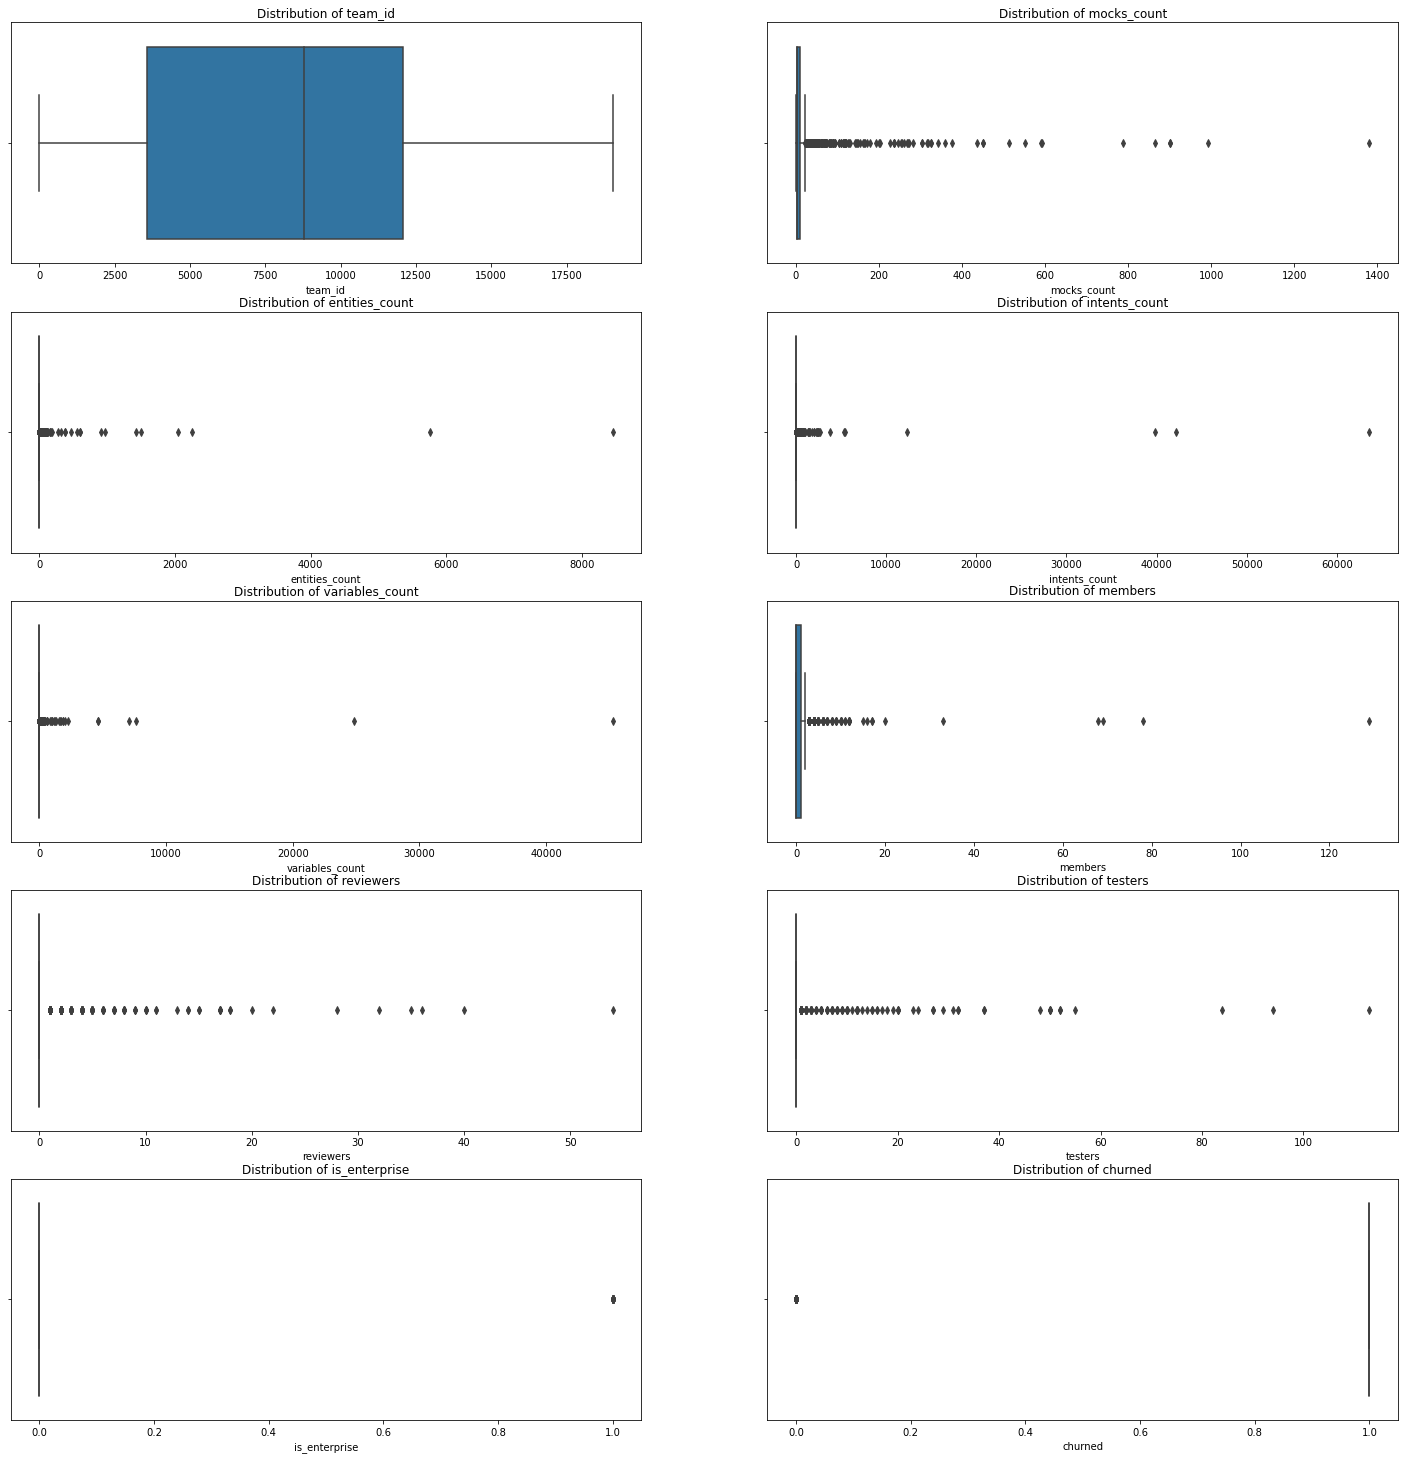

In [104]:
%matplotlib inline
fig = plt.subplots(figsize=(20, 20))
plt.tight_layout()

for plot, col in zip(range(1,11), features.columns):
    
    plt.subplot(5,2,plot)
    sns.boxplot(x=features[col])
    plt.title(f"Distribution of {col}")

The distribution of discrete variables are skewed overwhelmingly positive but with extremely long tails, indicating that most accounts are at the lower end of usage, and those accounts that are outliers vastly outweigh the lower usage accounts. We'll need to deal with these.

In [105]:
z = np.abs(stats.zscore(features))
features = features[(z < 3).all(axis=1)]

In [106]:
print(df.shape)
print(features.shape)
print(f'Count of accounts removed from analysis: {df.shape[0]-features.shape[0]}')

(1147, 15)
(1083, 10)
Count of accounts removed from analysis: 64


Only 64 accounts were removed as outliers. Let's look at the distribution now:

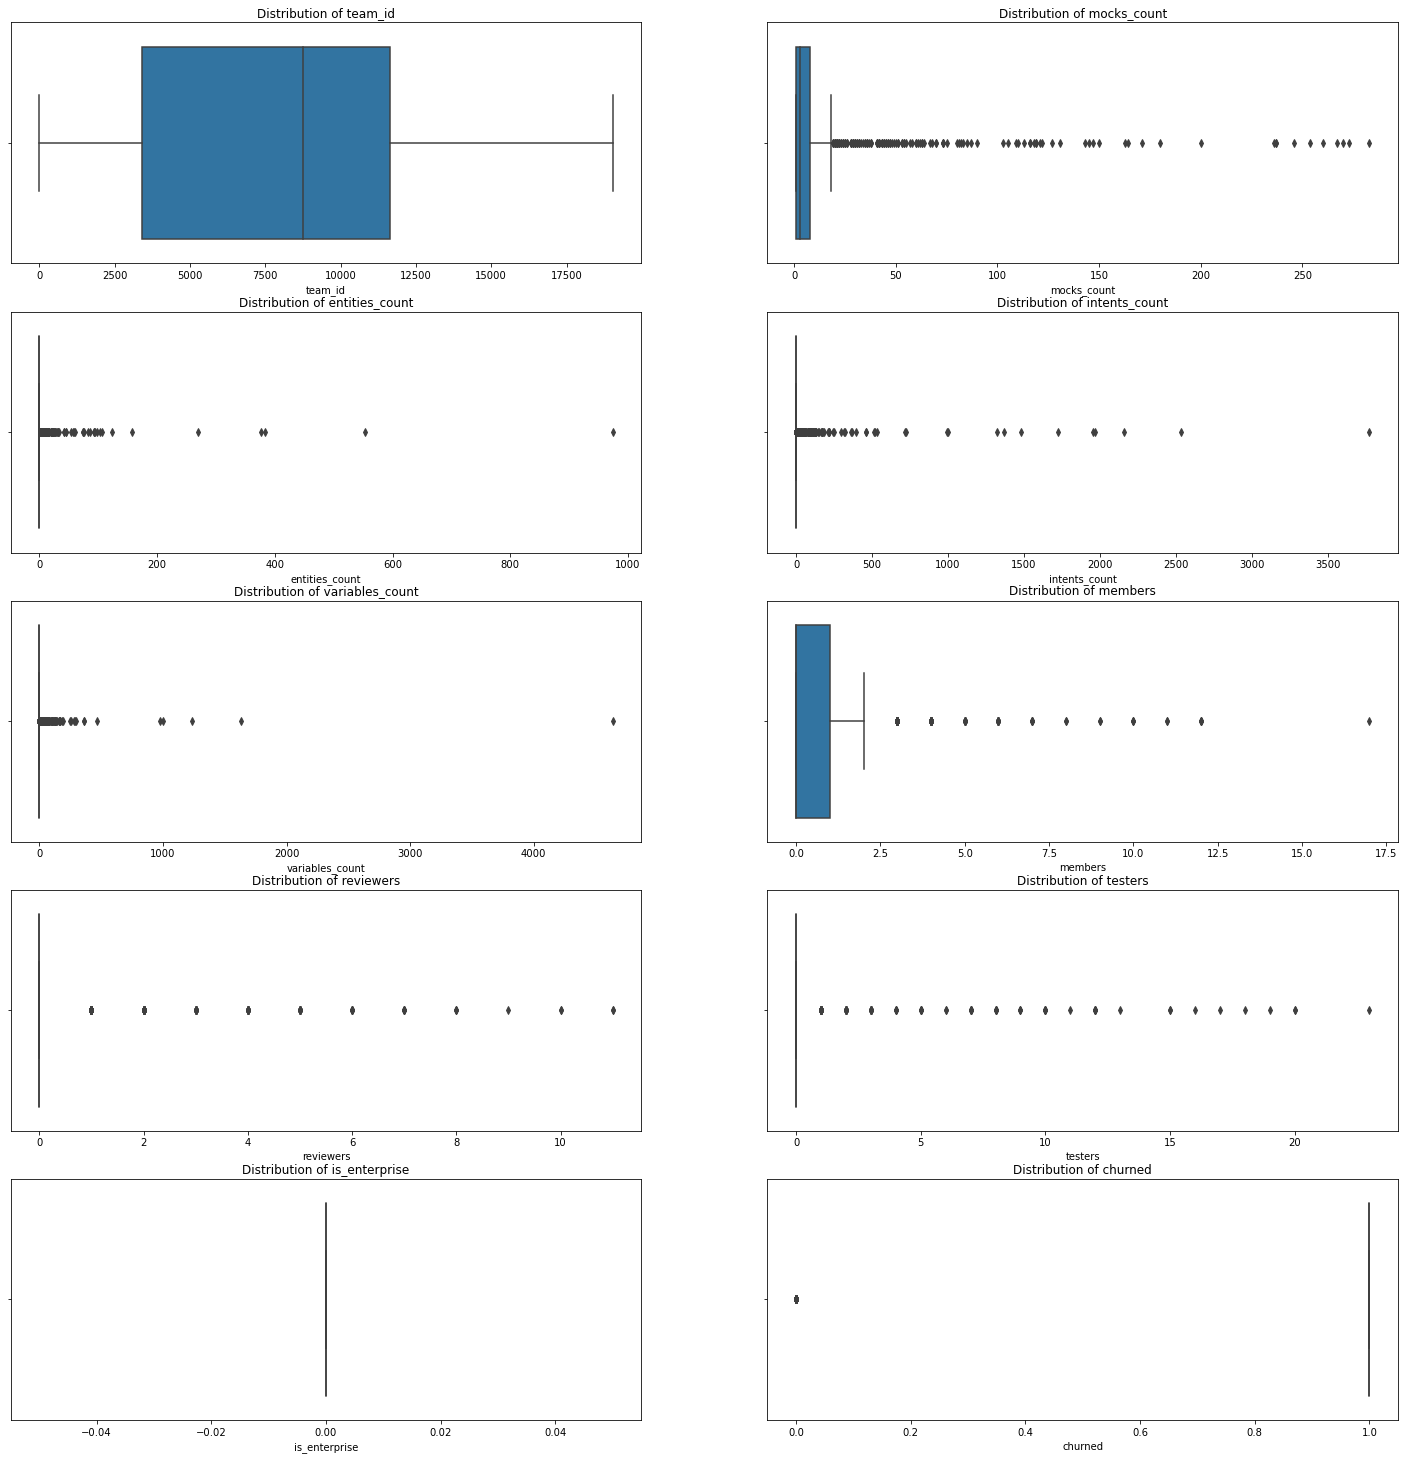

In [107]:
%matplotlib inline
fig = plt.subplots(figsize=(20, 20))
plt.tight_layout()

for plot, col in zip(range(1,11), features.columns):
    
    plt.subplot(5,2,plot)
    sns.boxplot(x=features[col])
    plt.title(f"Distribution of {col}")

Removing the outliers made the distribution marginally better. We may have to normalize the counts in order to run any predictive measures against the data, but we'll keep it like this for now. 

One other interesting point is that by removing the outliers, we removed all enterprise accounts. 

In [108]:
df.is_enterprise.value_counts()

0    1126
1      21
Name: is_enterprise, dtype: int64

In [109]:
features.is_enterprise.value_counts()

0    1083
Name: is_enterprise, dtype: int64

## Mocks EDA

In [110]:
# Groupby retained and messages then get into the right format
mocks = features.groupby(['churned', 'mocks_count']).count()['team_id'].unstack().reset_index(drop=True).rename_axis(None, axis=1)
mocks = mocks.T
mocks.fillna(0, inplace=True)
mocks

0      1
1    18.0  267.0
2    11.0  151.0
3    12.0  100.0
4     7.0   68.0
5     6.0   53.0
..    ...    ...
260   1.0    0.0
267   0.0    1.0
270   1.0    0.0
273   0.0    1.0
283   0.0    1.0

[100 rows x 2 columns]

In [111]:
# Add a actions label column
mocks['actions'] = mocks.index
mocks['actions'] = mocks['actions'].astype(str).apply(lambda x: "mocks: " + x)
mocks

0      1     actions
1    18.0  267.0    mocks: 1
2    11.0  151.0    mocks: 2
3    12.0  100.0    mocks: 3
4     7.0   68.0    mocks: 4
5     6.0   53.0    mocks: 5
..    ...    ...         ...
260   1.0    0.0  mocks: 260
267   0.0    1.0  mocks: 267
270   1.0    0.0  mocks: 270
273   0.0    1.0  mocks: 273
283   0.0    1.0  mocks: 283

[100 rows x 3 columns]

In [112]:
# Rename and rearrange columns
mocks.rename(
  columns={
    0 : 'retained',
    1 : 'churned'
  },
  inplace=True
)
mocks = mocks.reindex(columns=['actions', 'churned', 'retained'])
mocks['total'] = mocks['retained'] + mocks['churned']
mocks

actions  churned  retained  total
1      mocks: 1    267.0      18.0  285.0
2      mocks: 2    151.0      11.0  162.0
3      mocks: 3    100.0      12.0  112.0
4      mocks: 4     68.0       7.0   75.0
5      mocks: 5     53.0       6.0   59.0
..          ...      ...       ...    ...
260  mocks: 260      0.0       1.0    1.0
267  mocks: 267      1.0       0.0    1.0
270  mocks: 270      0.0       1.0    1.0
273  mocks: 273      1.0       0.0    1.0
283  mocks: 283      1.0       0.0    1.0

[100 rows x 4 columns]

In [114]:
# Calculate the percentage retained and make churned negative
mocks['percentage'] = round(mocks['retained'] / mocks['total'],2)
mocks['all'] = 1
mocks['churned'] = mocks['churned'] - (mocks['churned']*2)
mocks = mocks.loc[mocks.total >2]
mocks.head()

actions  churned  retained  total  percentage  all
1  mocks: 1   -267.0      18.0  285.0        0.06    1
2  mocks: 2   -151.0      11.0  162.0        0.07    1
3  mocks: 3   -100.0      12.0  112.0        0.11    1
4  mocks: 4    -68.0       7.0   75.0        0.09    1
5  mocks: 5    -53.0       6.0   59.0        0.10    1

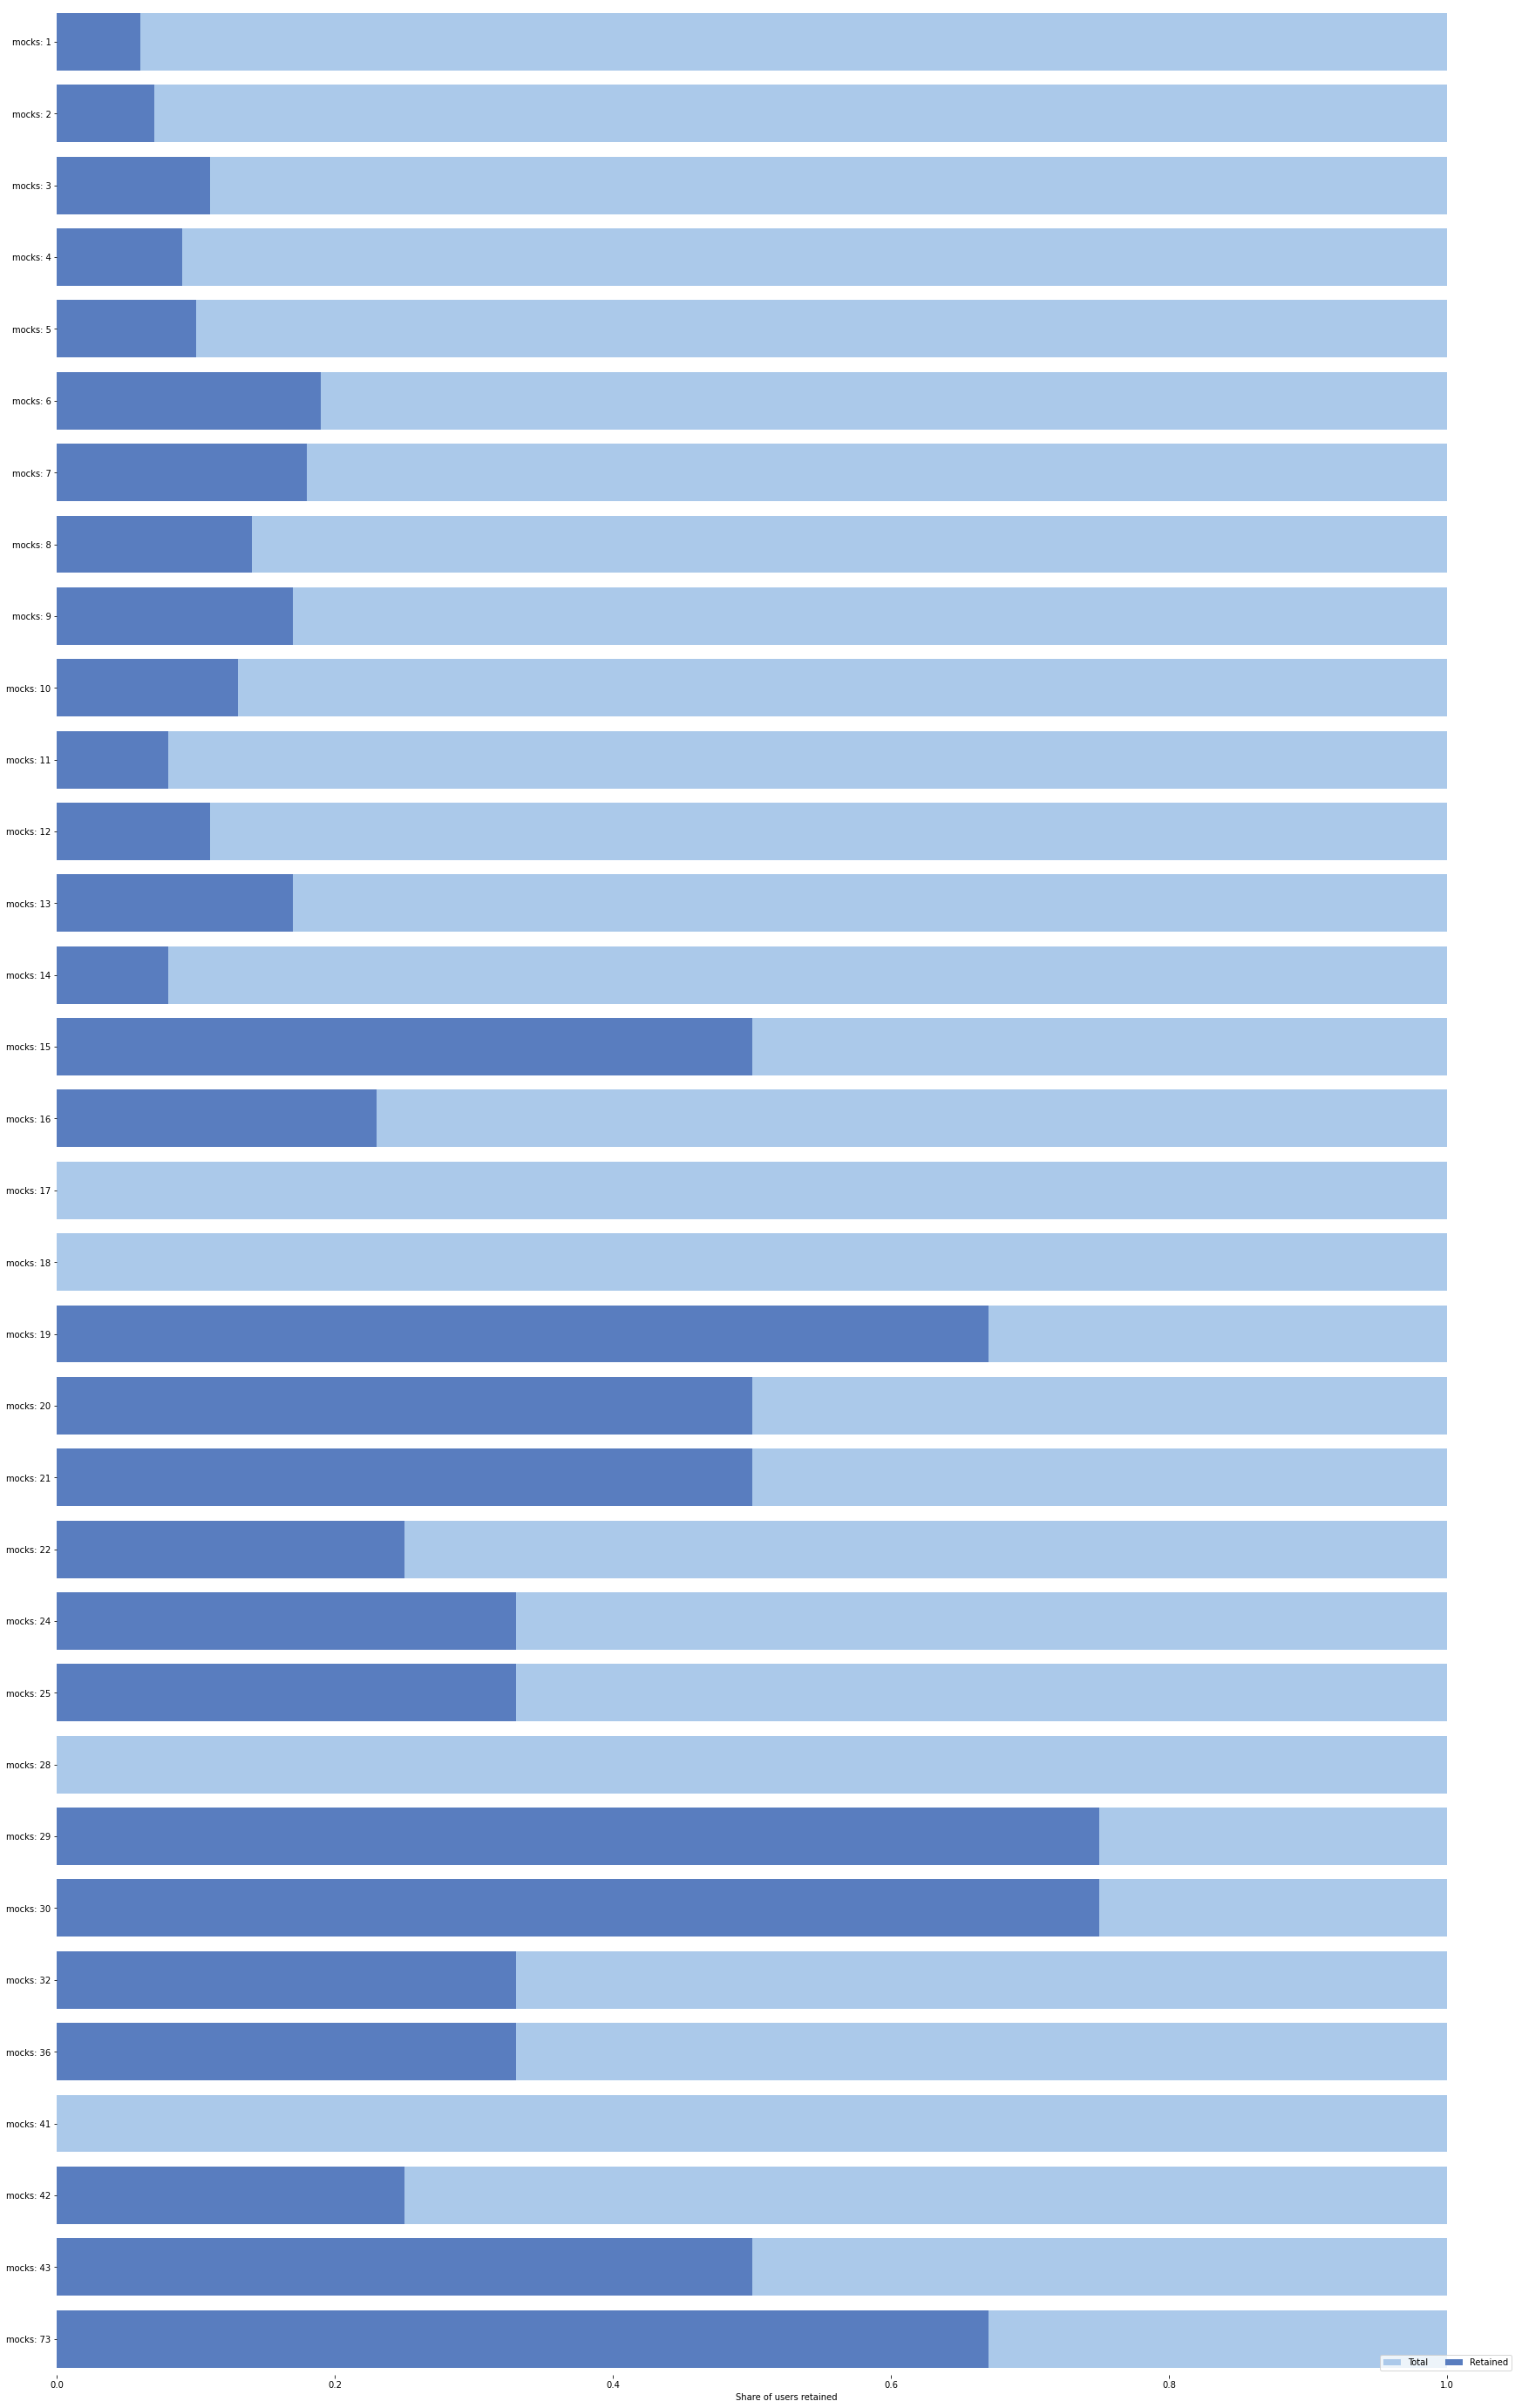

In [115]:
# Plot the share of users retained

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="all", y="actions", data=mocks,
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="percentage", y="actions", data=mocks,
            label="Retained", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Share of users retained")
sns.despine(left=True, bottom=True)

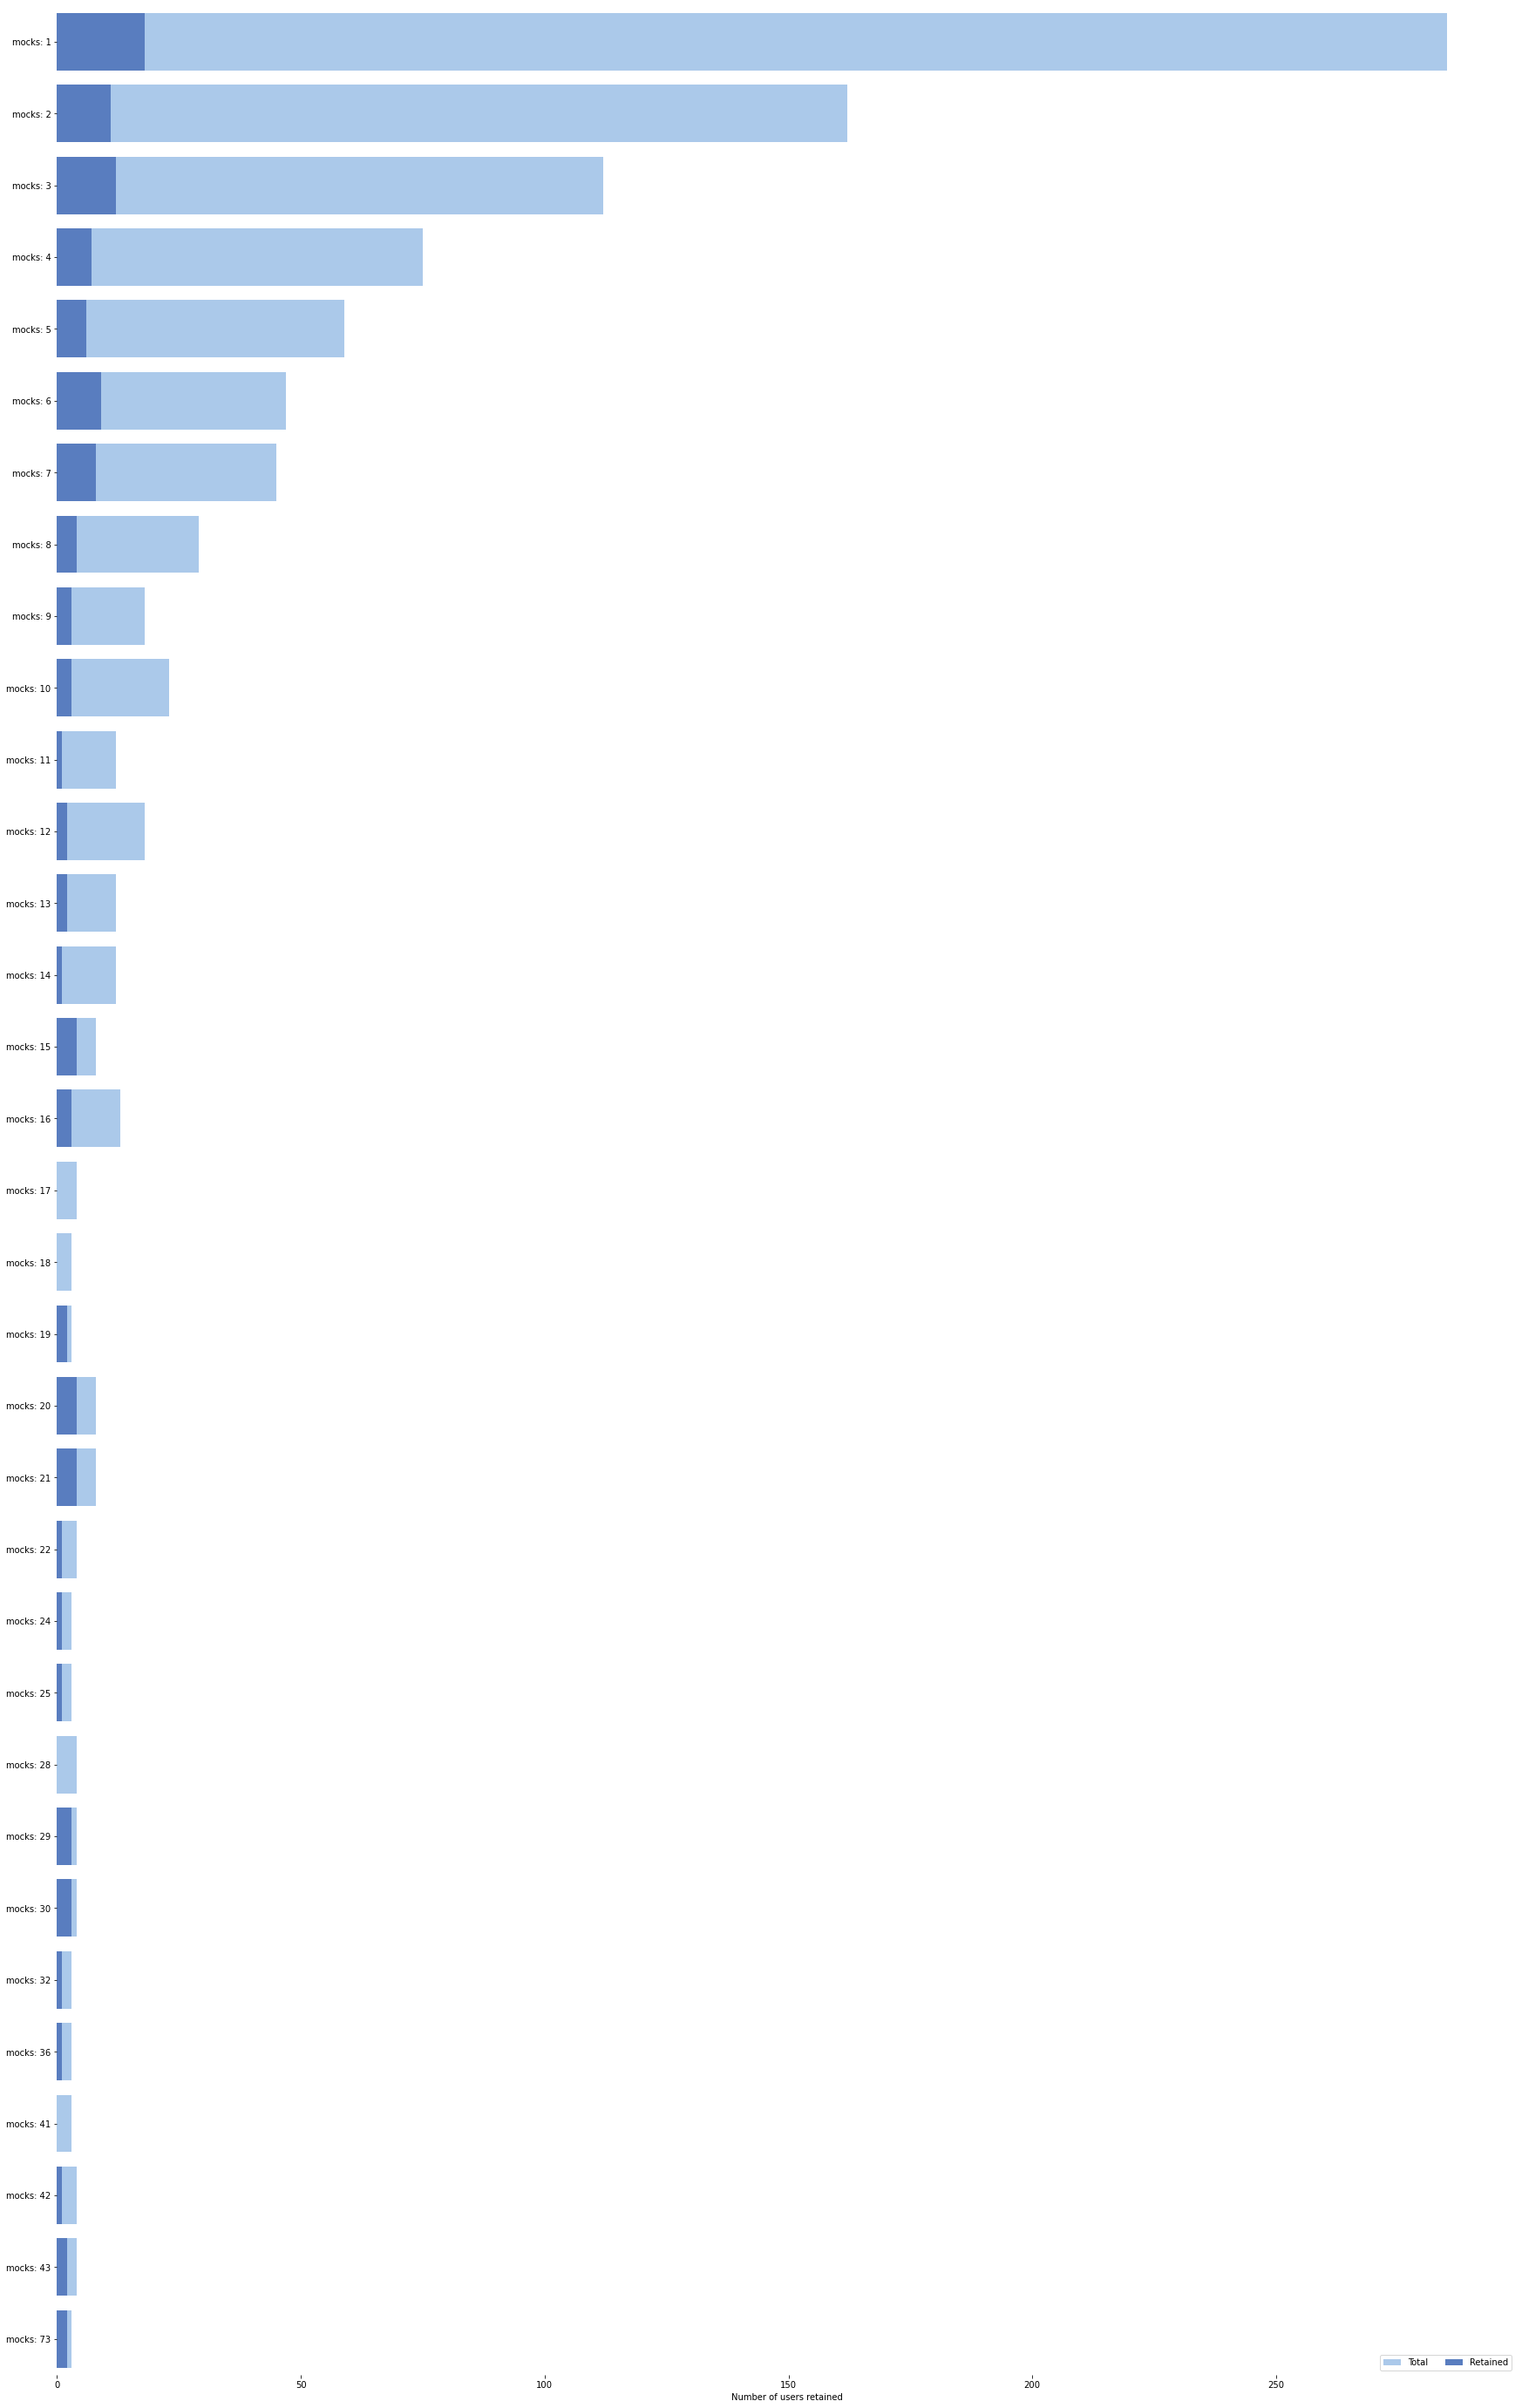

In [116]:
# Plot the Number of users retained

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="total", y="actions", data=mocks,
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="retained", y="actions", data=mocks,
            label="Retained", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of users retained")
sns.despine(left=True, bottom=True)

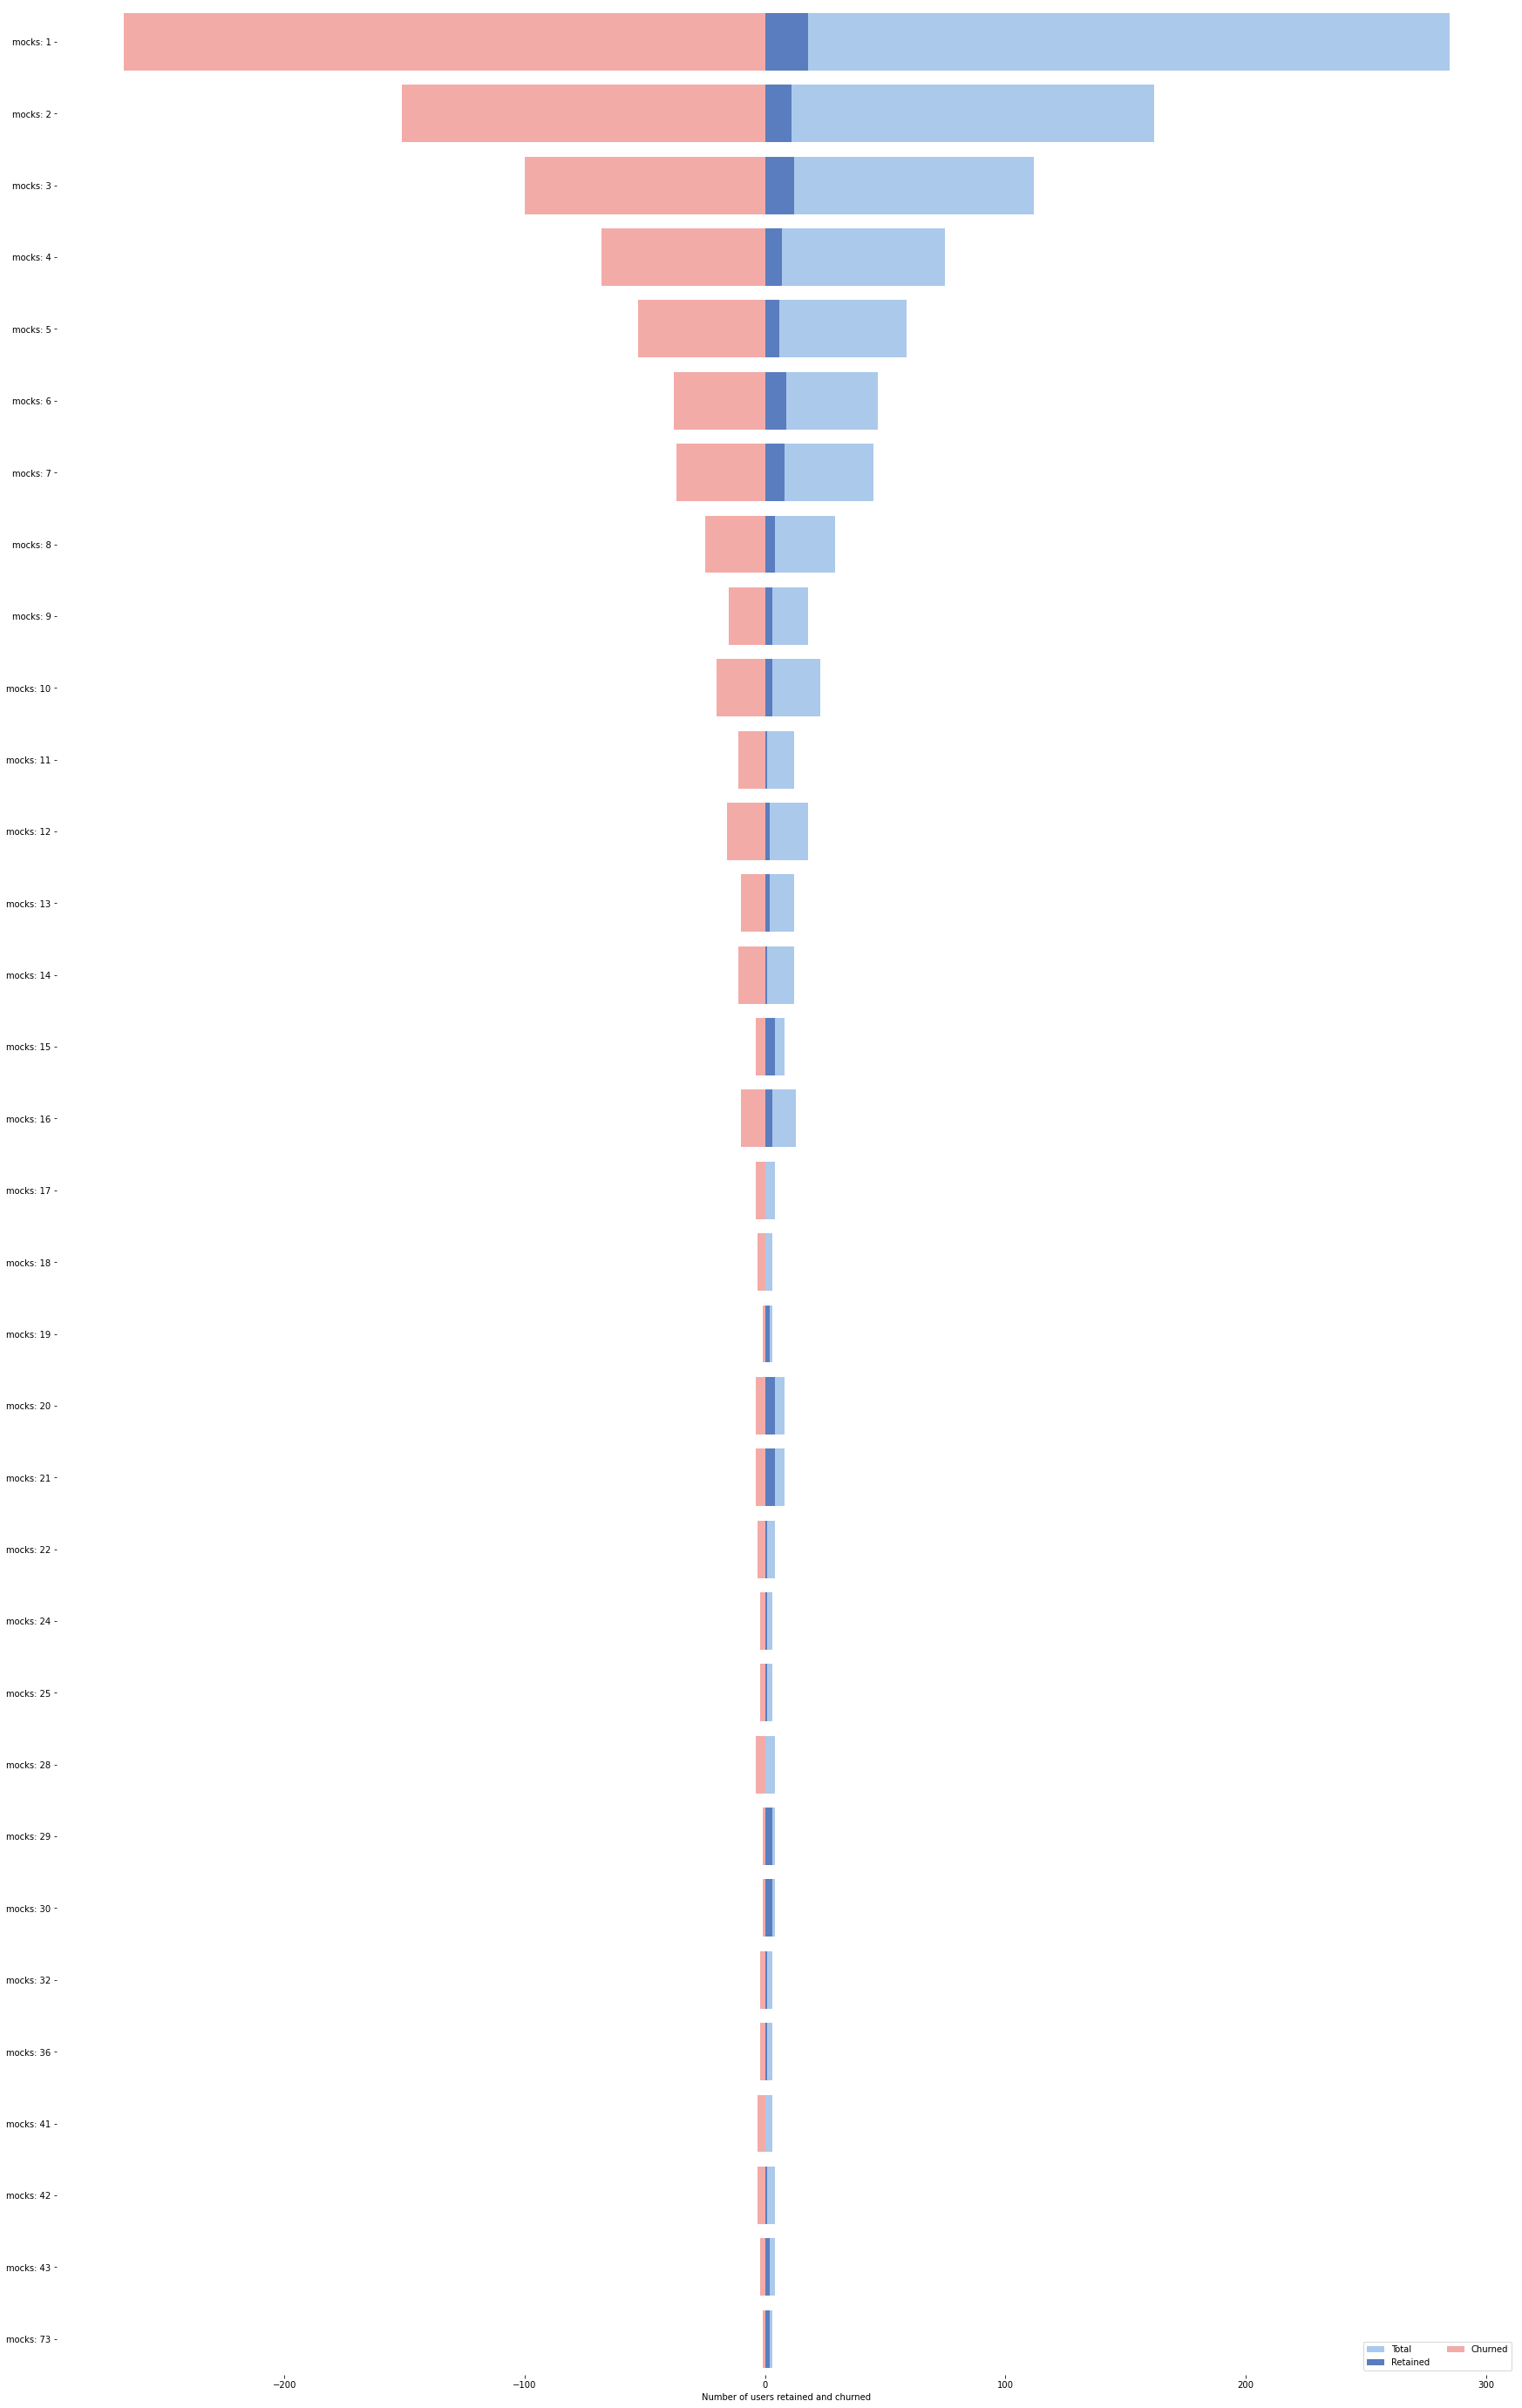

In [117]:
# Plot the number of users retained and churned

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="total", y="actions", data=mocks,
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="retained", y="actions", data=mocks,
            label="Retained", color="b")

# Plot the messages where user was retained
sns.set_color_codes("pastel")
sns.barplot(x="churned", y="actions", data=mocks,
            label="Churned", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of users retained and churned")
sns.despine(left=True, bottom=True)

In [118]:
# Calculate the cumulative retained figures
mocks['retained_cum'] = mocks['retained'].cumsum()
mocks['retained_cum'] = mocks['retained_cum'] - mocks['retained']
mocks['retained_cum_neg'] = mocks['retained_cum'] - (mocks['retained_cum']*2)
mocks[0:]

actions  churned  retained  total  percentage  all  retained_cum  \
1    mocks: 1   -267.0      18.0  285.0        0.06    1           0.0   
2    mocks: 2   -151.0      11.0  162.0        0.07    1          18.0   
3    mocks: 3   -100.0      12.0  112.0        0.11    1          29.0   
4    mocks: 4    -68.0       7.0   75.0        0.09    1          41.0   
5    mocks: 5    -53.0       6.0   59.0        0.10    1          48.0   
6    mocks: 6    -38.0       9.0   47.0        0.19    1          54.0   
7    mocks: 7    -37.0       8.0   45.0        0.18    1          63.0   
8    mocks: 8    -25.0       4.0   29.0        0.14    1          71.0   
9    mocks: 9    -15.0       3.0   18.0        0.17    1          75.0   
10  mocks: 10    -20.0       3.0   23.0        0.13    1          78.0   
11  mocks: 11    -11.0       1.0   12.0        0.08    1          81.0   
12  mocks: 12    -16.0       2.0   18.0        0.11    1          82.0   
13  mocks: 13    -10.0       2.0   12.0        0.17    1          84.0   
14  mocks: 14    -11.0       1.0   12.0        0.08    1          86.0   
15  mocks: 15     -4.0       4.0    8.0        0.50    1          87.0   
16  mocks: 16    -10.0       3.0   13.0        0.23    1          91.0   
17  mocks: 17     -4.0       0.0    4.0        0.00    1          94.0   
18  mocks: 18     -3.0       0.0    3.0        0.00    1          94.0   
19  mocks: 19     -1.0       2.0    3.0        0.67    1          94.0   
20  mocks: 20     -4.0       4.0    8.0        0.50    1          96.0   
21  mocks: 21     -4.0       4.0    8.0        0.50    1         100.0   
22  mocks: 22     -3.0       1.0    4.0        0.25    1         104.0   
24  mocks: 24     -2.0       1.0    3.0        0.33    1         105.0   
25  mocks: 25     -2.0       1.0    3.0        0.33    1         106.0   
28  mocks: 28     -4.0       0.0    4.0        0.00    1         107.0   
29  mocks: 29     -1.0       3.0    4.0        0.75    1         107.0   
30  mocks: 30     -1.0       3.0    4.0        0.75    1         110.0   
32  mocks: 32     -2.0       1.0    3.0        0.33    1         113.0   
36  mocks: 36     -2.0       1.0    3.0        0.33    1         114.0   
41  mocks: 41     -3.0       0.0    3.0        0.00    1         115.0   
42  mocks: 42     -3.0       1.0    4.0        0.25    1         115.0   
43  mocks: 43     -2.0       2.0    4.0        0.50    1         116.0   
73  mocks: 73     -1.0       2.0    3.0        0.67    1         118.0   

    retained_cum_neg  
1                0.0  
2              -18.0  
3              -29.0  
4              -41.0  
5              -48.0  
6              -54.0  
7              -63.0  
8              -71.0  
9              -75.0  
10             -78.0  
11             -81.0  
12             -82.0  
13             -84.0  
14             -86.0  
15             -87.0  
16             -91.0  
17             -94.0  
18             -94.0  
19             -94.0  
20             -96.0  
21            -100.0  
22            -104.0  
24            -105.0  
25            -106.0  
28            -107.0  
29            -107.0  
30            -110.0  
32            -113.0  
36            -114.0  
41            -115.0  
42            -115.0  
43            -116.0  
73            -118.0

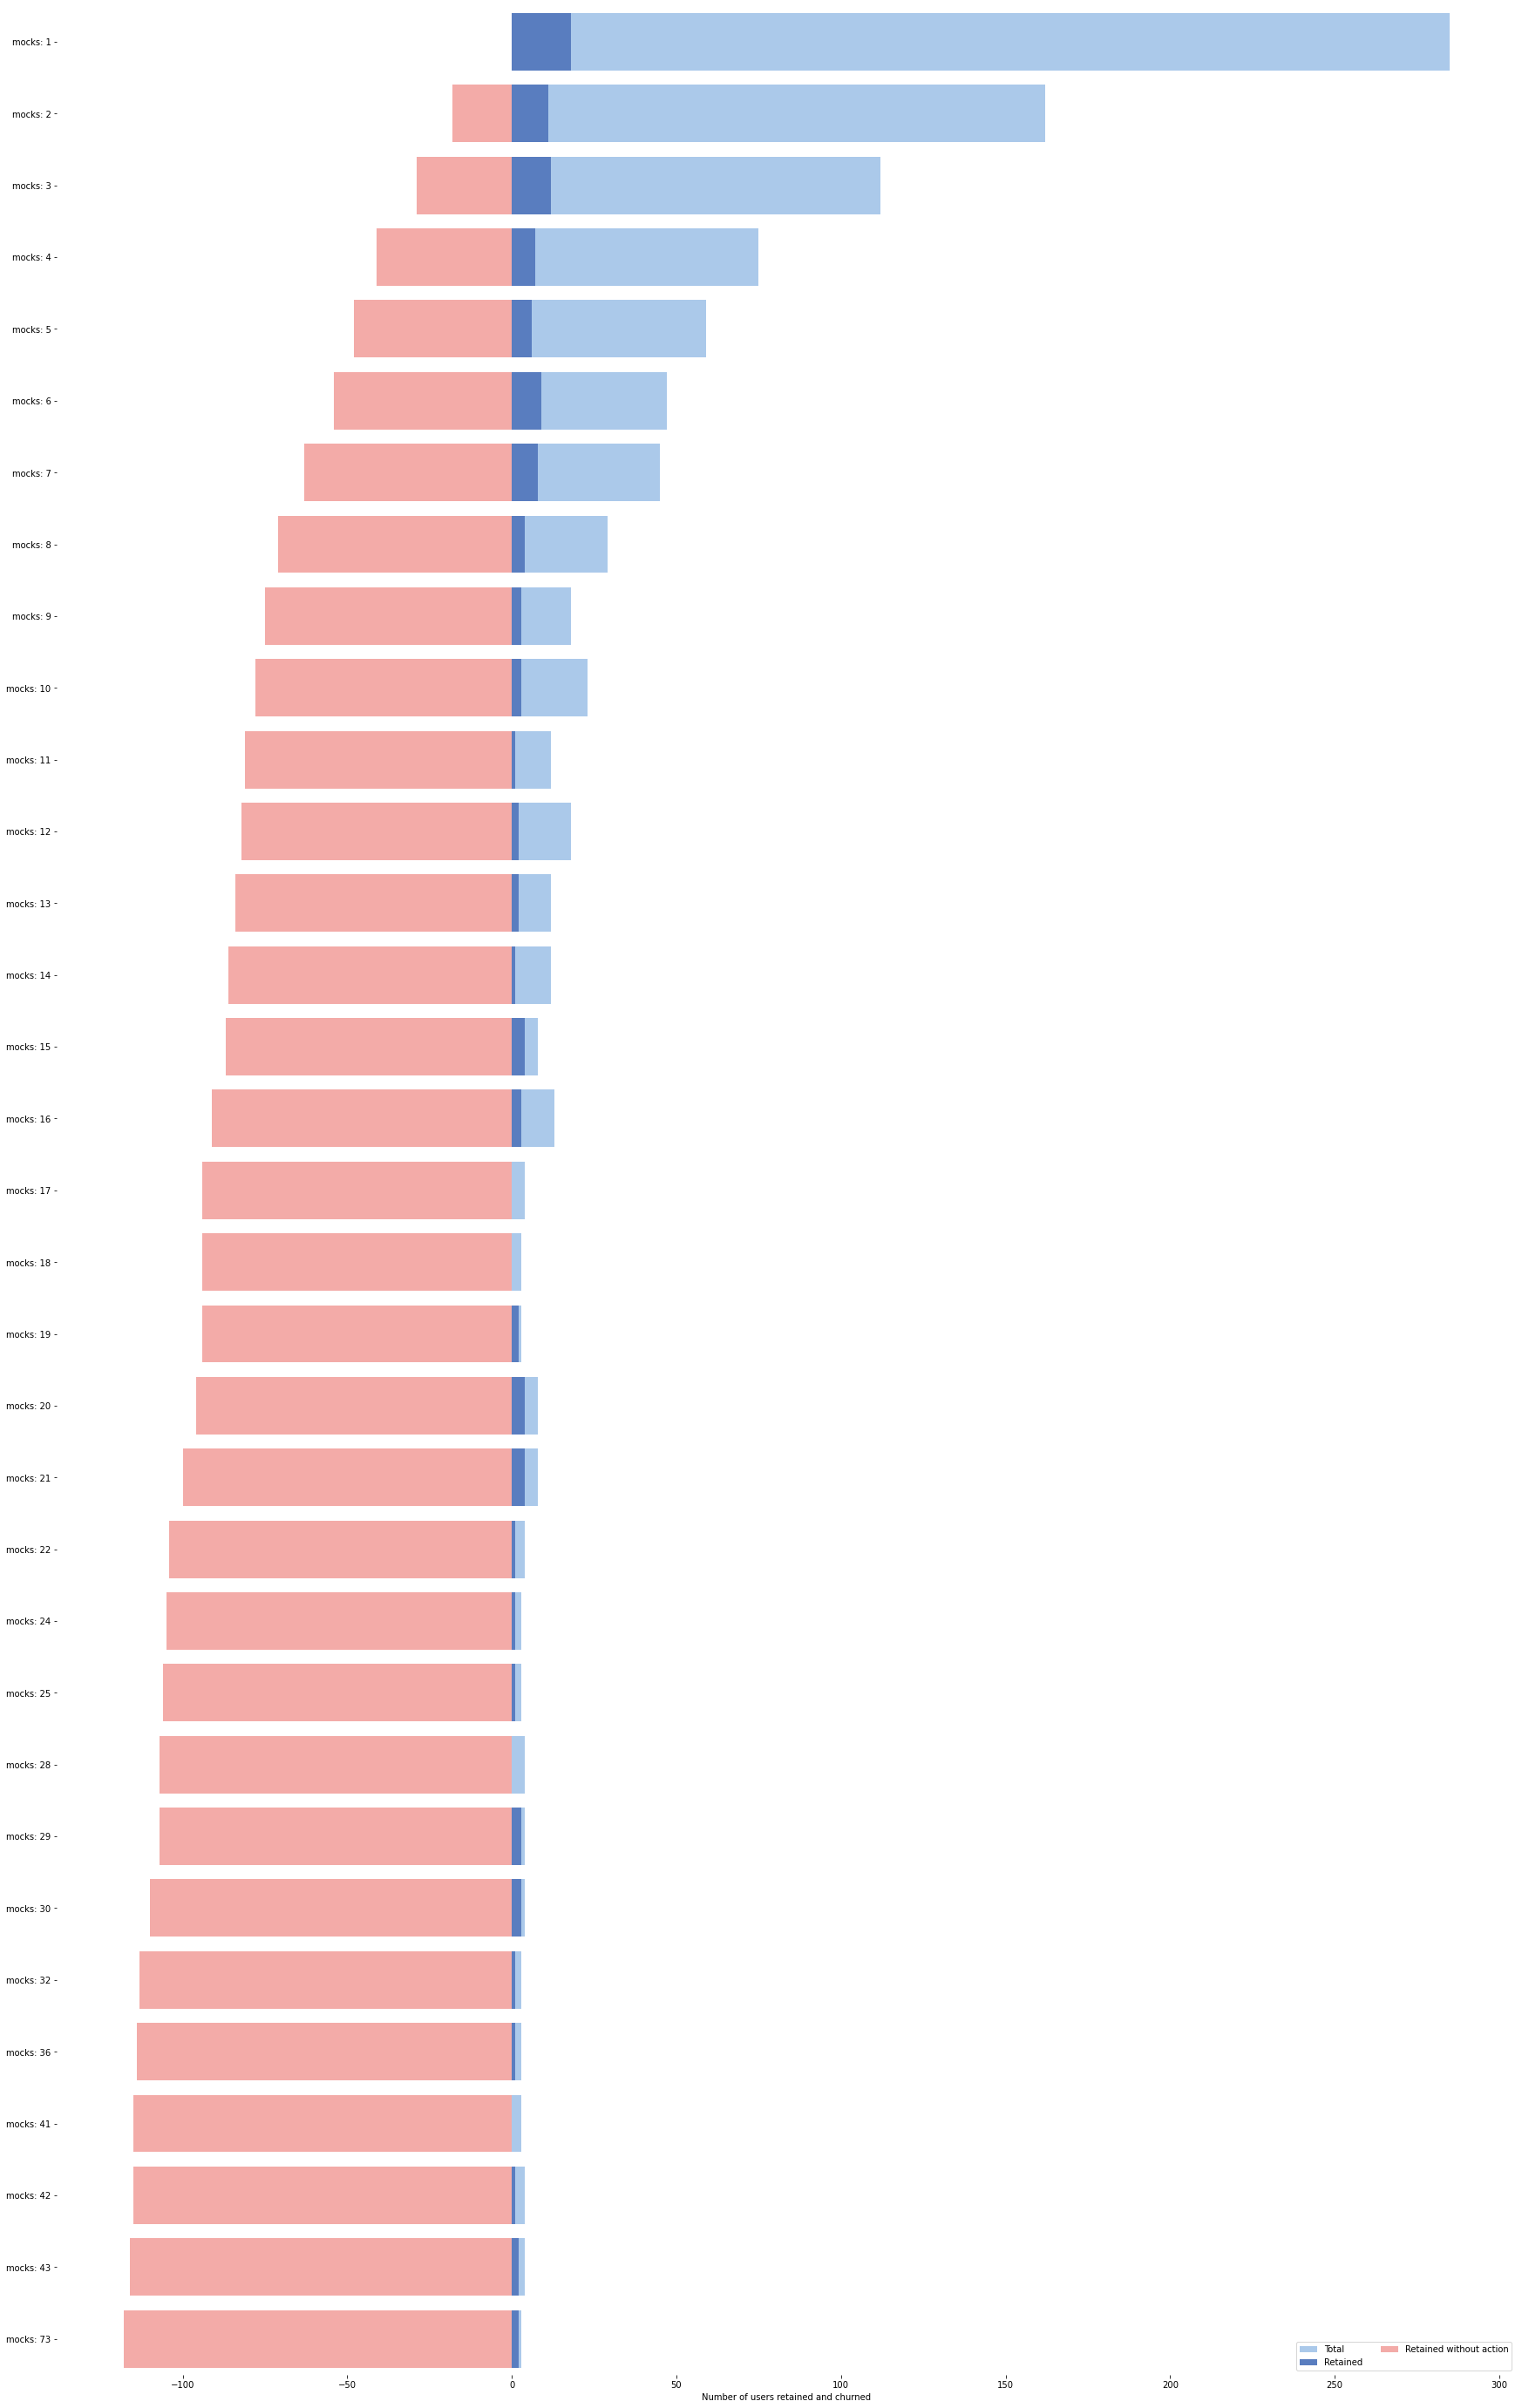

In [119]:
# Plot the number of users retained without action

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="total", y="actions", data=mocks[0:],
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="retained", y="actions", data=mocks[0:],
            label="Retained", color="b")

# Plot the messages where user was retained
sns.set_color_codes("pastel")
sns.barplot(x="retained_cum_neg", y="actions", data=mocks[0:],
            label="Retained without action", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of users retained and churned")
sns.despine(left=True, bottom=True)

In [120]:
# Work out retained percentage
mocks['total_retained'] = mocks['retained'].sum()
mocks['retained_percentage'] = mocks['retained_cum'] / mocks['total_retained']
mocks.head()

actions  churned  retained  total  percentage  all  retained_cum  \
1  mocks: 1   -267.0      18.0  285.0        0.06    1           0.0   
2  mocks: 2   -151.0      11.0  162.0        0.07    1          18.0   
3  mocks: 3   -100.0      12.0  112.0        0.11    1          29.0   
4  mocks: 4    -68.0       7.0   75.0        0.09    1          41.0   
5  mocks: 5    -53.0       6.0   59.0        0.10    1          48.0   

   retained_cum_neg  total_retained  retained_percentage  
1               0.0           120.0             0.000000  
2             -18.0           120.0             0.150000  
3             -29.0           120.0             0.241667  
4             -41.0           120.0             0.341667  
5             -48.0           120.0             0.400000

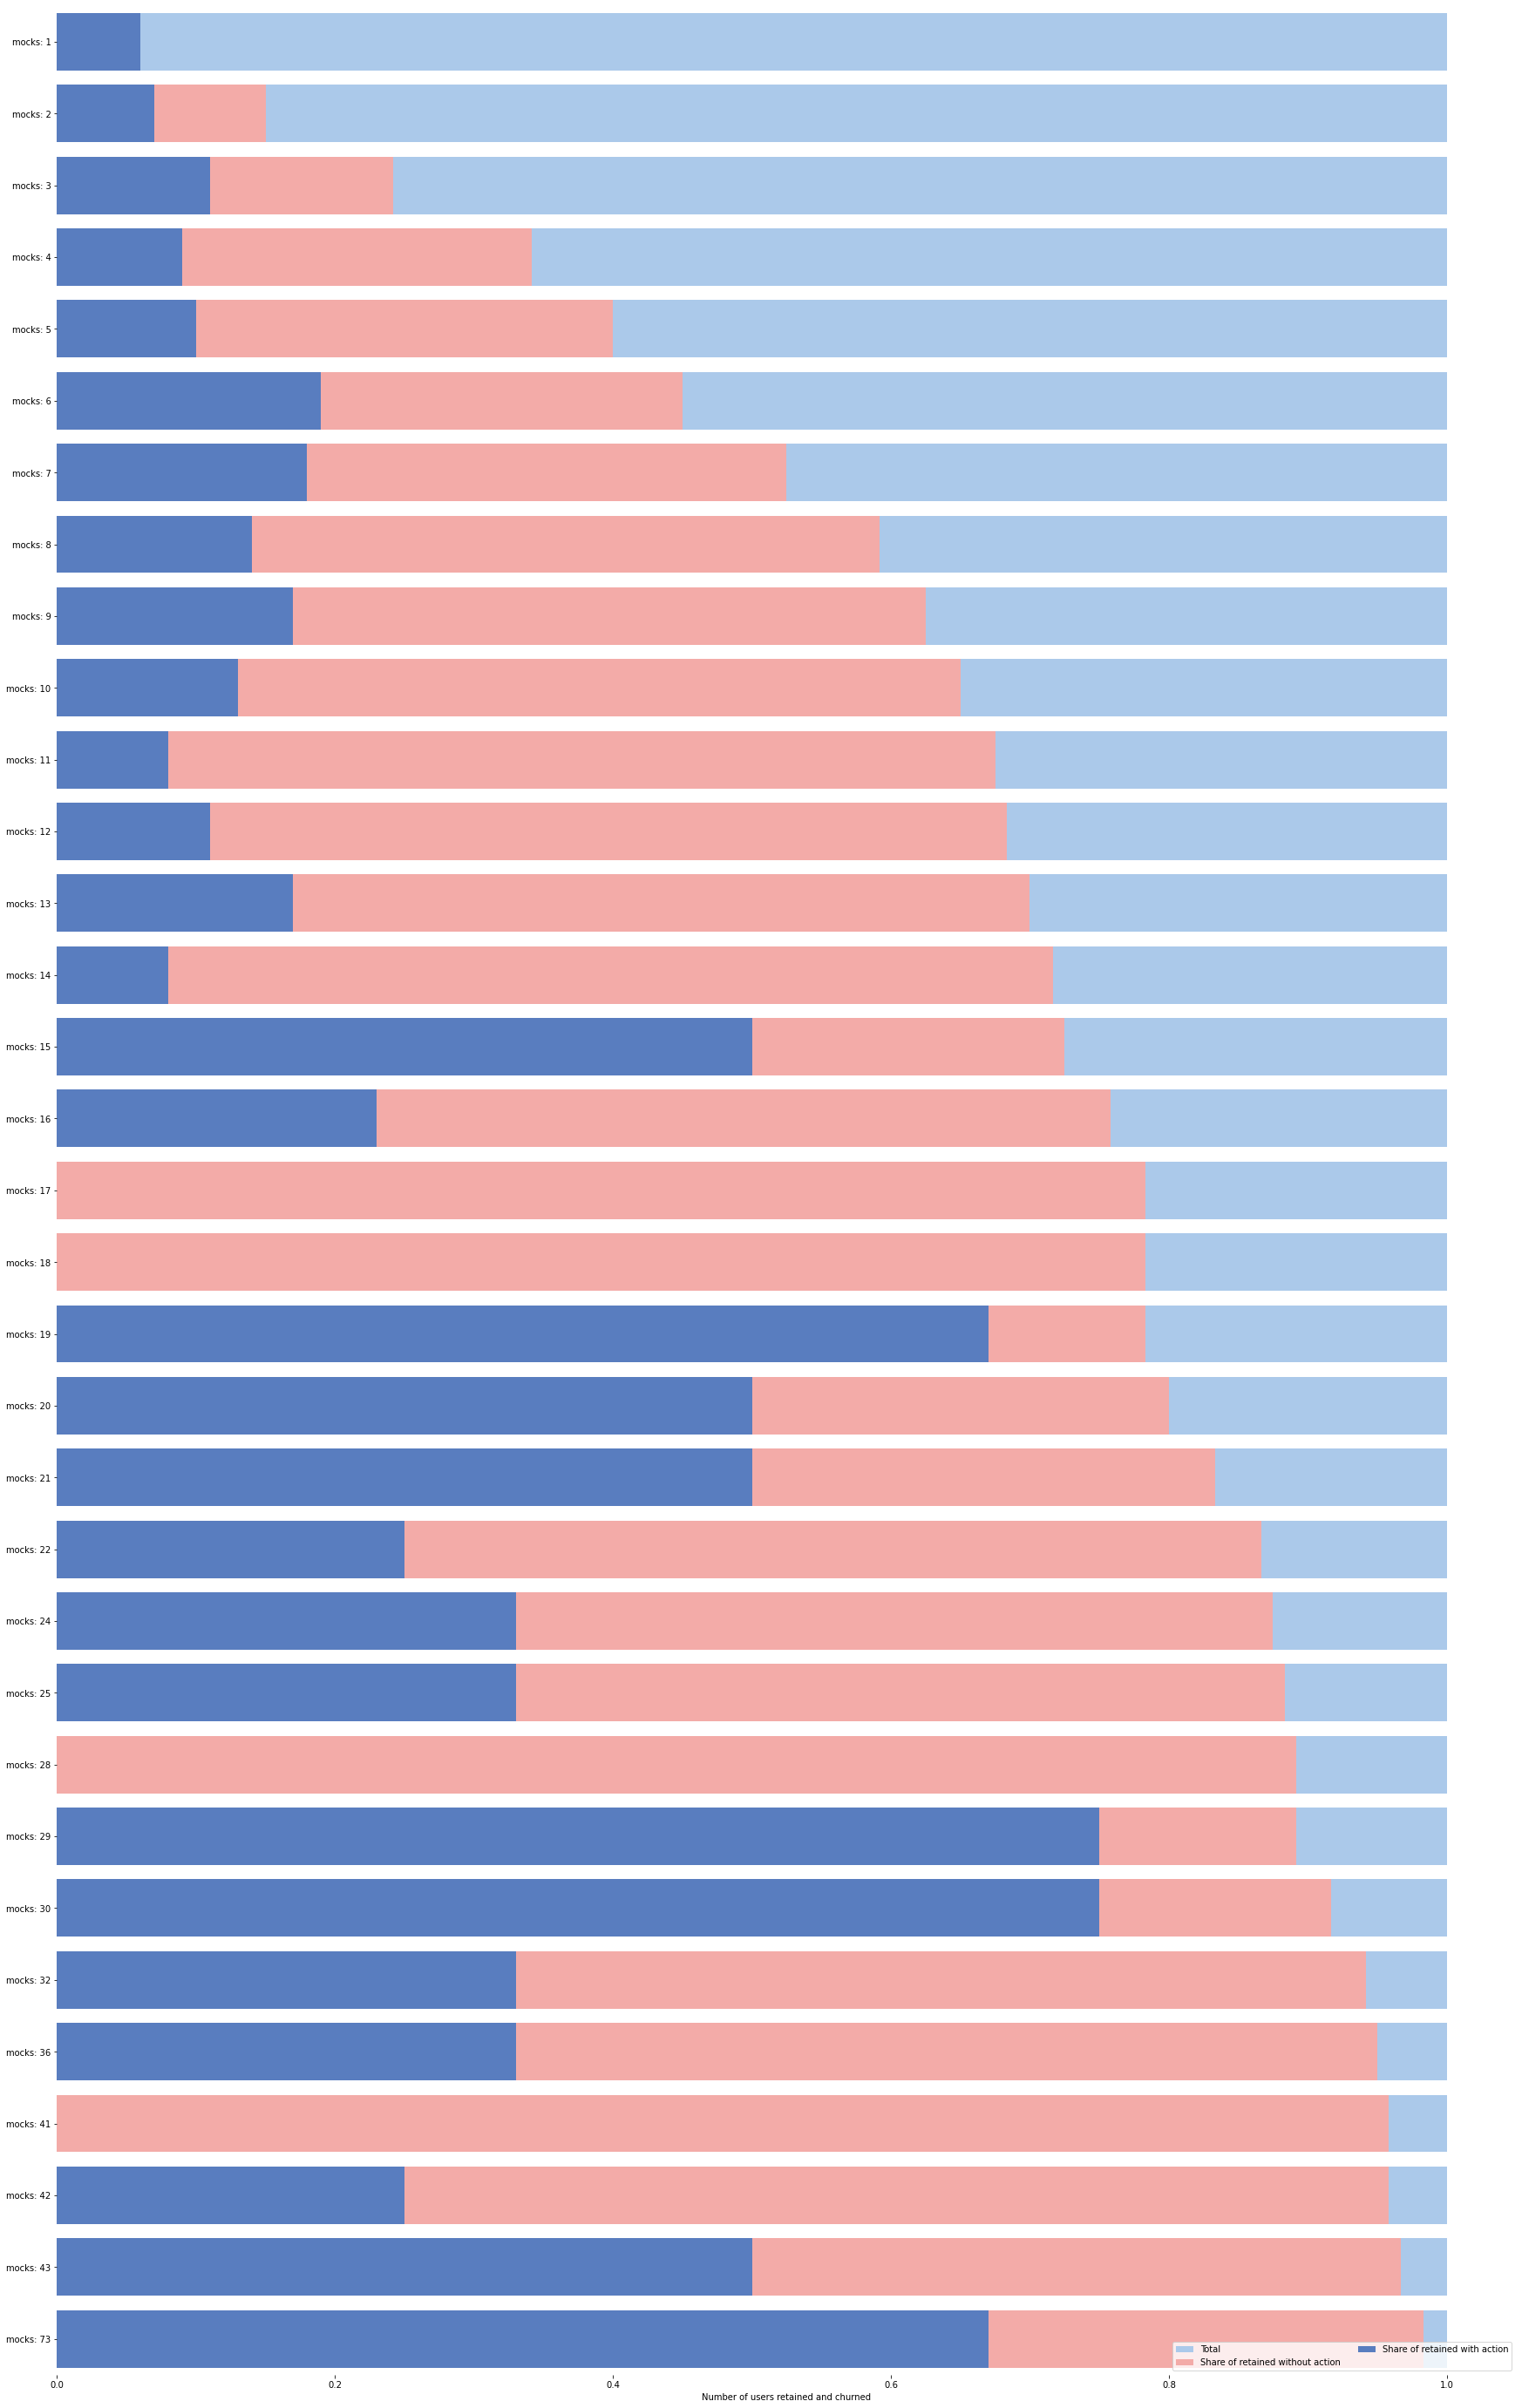

In [121]:
# Plot share retained with action vs without action

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(30, 50))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="all", y="actions", data=mocks[0:],
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("pastel")
sns.barplot(x="retained_percentage", y="actions", data=mocks[0:],
            label="Share of retained without action", color="r")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="percentage", y="actions", data=mocks[0:],
            label="Share of retained with action", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of users retained and churned")
sns.despine(left=True, bottom=True)

In [122]:
# Calculate the difference between retained with and without action
mocks['diff'] = mocks['percentage'] - mocks['retained_percentage']
mocks.head()

actions  churned  retained  total  percentage  all  retained_cum  \
1  mocks: 1   -267.0      18.0  285.0        0.06    1           0.0   
2  mocks: 2   -151.0      11.0  162.0        0.07    1          18.0   
3  mocks: 3   -100.0      12.0  112.0        0.11    1          29.0   
4  mocks: 4    -68.0       7.0   75.0        0.09    1          41.0   
5  mocks: 5    -53.0       6.0   59.0        0.10    1          48.0   

   retained_cum_neg  total_retained  retained_percentage      diff  
1               0.0           120.0             0.000000  0.060000  
2             -18.0           120.0             0.150000 -0.080000  
3             -29.0           120.0             0.241667 -0.131667  
4             -41.0           120.0             0.341667 -0.251667  
5             -48.0           120.0             0.400000 -0.300000

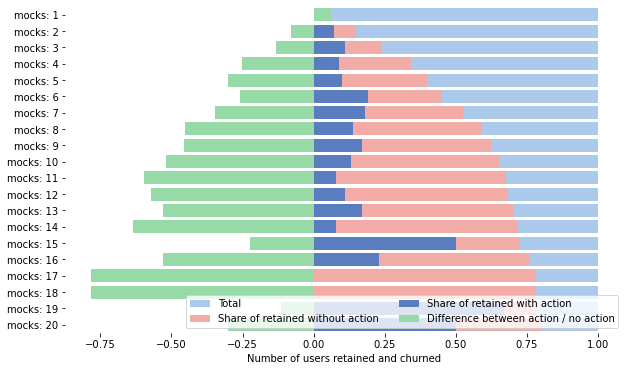

In [123]:
# Plot the difference between retained with action and without action

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 6))

# Plot the total messages
sns.set_color_codes("pastel")
sns.barplot(x="all", y="actions", data=mocks[0:20],
            label="Total", color="b")

# Plot the messages where user was retained
sns.set_color_codes("pastel")
sns.barplot(x="retained_percentage", y="actions", data=mocks[0:20],
            label="Share of retained without action", color="r")

# Plot the messages where user was retained
sns.set_color_codes("muted")
sns.barplot(x="percentage", y="actions", data=mocks[0:20],
            label="Share of retained with action", color="b")

# Plot the messages where user was retained
sns.set_color_codes("pastel")
sns.barplot(x="diff", y="actions", data=mocks[0:20],
            label="Difference between action / no action", color="g")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylabel="", xlabel="Number of users retained and churned")
sns.despine(left=True, bottom=True)

In [128]:
feature_df_names = ['entities','intents', 'variables','members','reviewers','testers']

In [131]:
feature_df_dict = dict(zip(feature_df_names,features.columns[2:8]))

In [132]:
feature_df_dict

{'entities': 'entities_count',
 'intents': 'intents_count',
 'variables': 'variables_count',
 'members': 'members',
 'reviewers': 'reviewers',
 'testers': 'testers'}

In [136]:
def feature_df_creation(dataframe, column, feature_name):

    df = features.groupby(['churned', column]).count()['team_id'].unstack().reset_index(drop=True).rename_axis(None, axis=1)
    df = df.T
    df.fillna(0, inplace=True)

    df['actions'] = df.index
    df['actions'] = df['actions'].astype(str).apply(lambda x: f"{feature_name}: " + x)

######
    df.rename(
      columns={
        0 : 'retained',
        1 : 'churned'
      },
      inplace=True
    )
    df = df.reindex(columns=['actions', 'churned', 'retained'])
    df['total'] = df['retained'] + df['churned']
    
########
    df['percentage'] = round(df['retained'] / df['total'],2)
    df['all'] = 1
    df['churned'] = df['churned'] - (df['churned']*2)
    df = df.loc[df.total >2]
    
########
    df['retained_cum'] = df['retained'].cumsum()
    df['retained_cum'] = df['retained_cum'] - df['retained']
    df['retained_cum_neg'] = df['retained_cum'] - (df['retained_cum']*2)
########
    df['total_retained'] = df['retained'].sum()
    df['retained_percentage'] =df['retained_cum'] / df['total_retained']
    
########
    df['diff'] = df['percentage'] - df['retained_percentage']
    
    return df

In [137]:
df_list = []

for name, column in feature_df_dict.items():
    name = feature_df_creation(features, column, name)
    df_list.append(name)

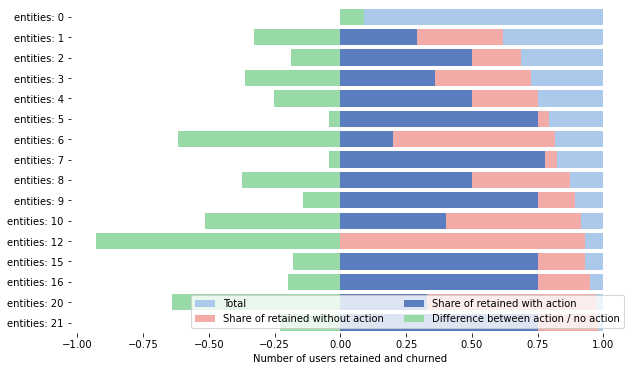

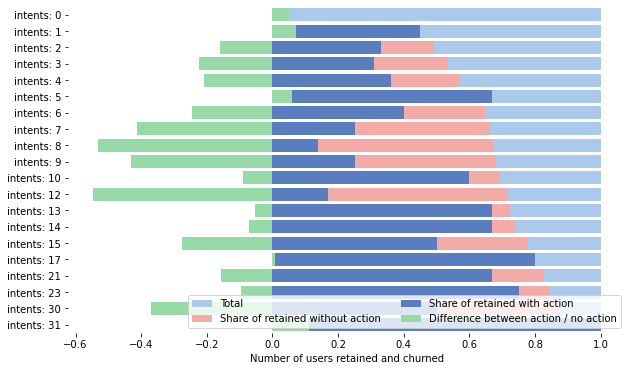

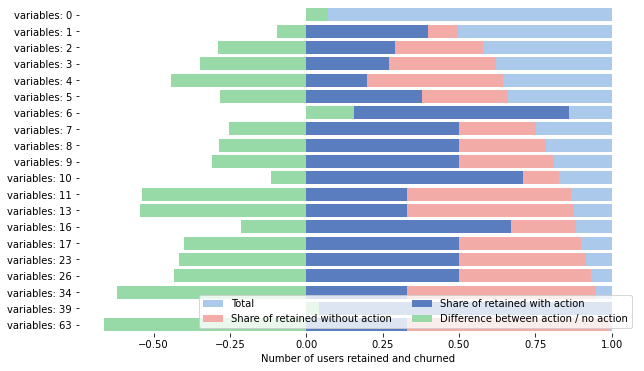

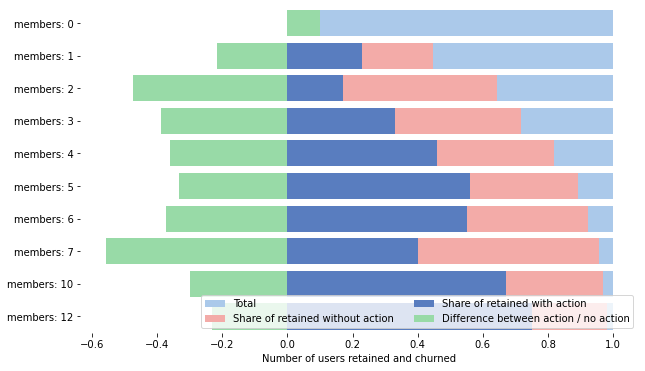

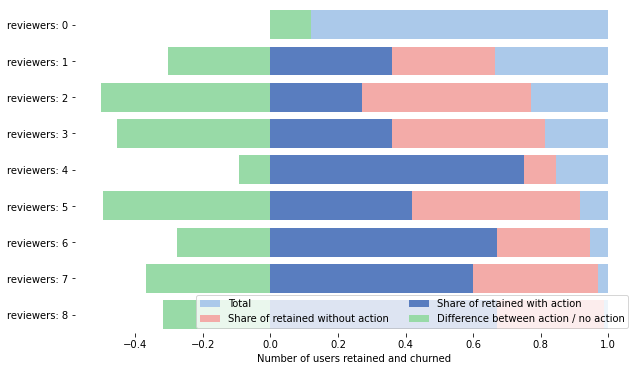

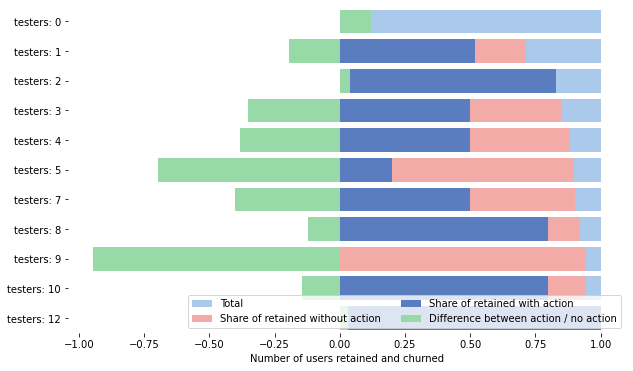

In [139]:
for df in df_list: 
    
    # Initialize the matplotlib figure
    f, ax = plt.subplots(figsize=(10, 6))

# Plot the total messages
    sns.set_color_codes("pastel")
    sns.barplot(x="all", y="actions", data=df[0:20],
                label="Total", color="b")

    # Plot the messages where user was retained
    sns.set_color_codes("pastel")
    sns.barplot(x="retained_percentage", y="actions", data=df[0:20],
                label="Share of retained without action", color="r")

    # Plot the messages where user was retained
    sns.set_color_codes("muted")
    sns.barplot(x="percentage", y="actions", data=df[0:20],
                label="Share of retained with action", color="b")

    # Plot the messages where user was retained
    sns.set_color_codes("pastel")
    sns.barplot(x="diff", y="actions", data=df[0:20],
                label="Difference between action / no action", color="g")

    # Add a legend and informative axis label
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(ylabel="", xlabel="Number of users retained and churned")
    sns.despine(left=True, bottom=True)